In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, vectorize

%matplotlib widget

@vectorize
def heaviside(x):
    if x < 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 0.5

$$
0.5 x_{i+\frac{1}{2}}^3 \sin{\frac{B_i}{x_{i}^2}}
$$

In [2]:
@njit
def tloop(B, X, dx, XN, T_final):
    t=0

    done = False
    while done == False:
        
        # CFL condition
        dt = CLF(B, X, dx)
        # Advance time
        if t + dt > T_final:
            dt = T_final - t
            t = T_final
            done = True
        else:
            t = t + dt

        Bt = B.copy()

        B[0] = 0 # inner boundary condition, since B = x*b, at x=0 we have B=0
        # flux from B(1) into B(2) is 0
        B[1] = Bt[1] - dt/dx * flux(Bt[1] / X[1]**2, Bt[2] / X[2]**2, (X[1] + X[2]) / 2)
        for j in range(2, XN-1):
            B[j] = Bt[j] - dt/dx * ( flux(Bt[j] / X[j]**2, Bt[j+1] / X[j+1]**2, (X[j] + X[j+1]) / 2) 
                                        - flux(Bt[j-1] / X[j-1]**2, Bt[j] / X[j]**2, (X[j-1] + X[j])/2) )
        # outer boundary condition: no dynamics for B(XN) (see limits on the
        # for loop above) implies no incoming matter from beyond XN.

        Rho1 = (Bt - B) / X**2 / (4*np.pi*dt) # from Eq. (4.15)
    return B, Rho1

@njit
def flux(ul, ur, x):
    FL = 0.5 * x**3 * np.sin(ul)**2 
    FR = 0.5 * x**3 * np.sin(ur)**2 
    ll = np.array([FL, FR])
    if ul <= ur:
        return np.min(ll)
    elif ul > ur:
        if ((ur > -np.pi/2) or (ul < -np.pi/2)):
            return np.max(ll)
        else:
            return 0.5 * x**3

@njit
def CLF(B, X, dx, fact = 0.45):
    # Set dt using velocity of characteristics
    vel = X * np.sin(B / X**2) * np.cos(B / X**2)
    v_min = np.min(vel)
    v_max = np.max(vel)
    v_abs = max(-v_min, v_max)

    # CFL condition
    dt = fact * dx / np.abs(v_abs)
    if dt > dx / 20:
       dt = dx / 20  # largest timestep allowed
    return dt

@njit
def der(f, h):
    f_x = np.zeros_like(f)
    f_x[0:3]   = (-147*f[0:3]+360*f[1:4]-450*f[2:5]+400*f[3:6]-225*f[4:7]+72*f[5:8]-10*f[6:9])/(60*h)
    f_x[-3:] = (10*f[-9:-6]-72*f[-8:-5]+225*f[-7:-4]-400*f[-6:-3]+450*f[-5:-2]-360*f[-4:-1]+147*f[-3:])/(60*h)
    f_x[3:-3]  = (-f[0:-6]+9*f[1:-5]-45*f[2:-4]+45*f[4:-2]-9*f[5:-1]+f[6:])/(60*h)
    return f_x

### Evolution loop

In [3]:
T_final = 2 #8.5*mass**2 + 40*mass

r0 = 15

m = 5
xm = 50.0
dx0 = 0.0125
n_div = 1
dxs = [dx0 / 2**i for i in range(n_div)]

print(dxs)

[0.0125]


In [4]:


saved = {}



for k, dx in enumerate(dxs):
    print(dx)
    X = np.linspace(0, xm, int(1 + xm / dx), dtype=np.float64) + 1e-16
    XN = len(X)

    # print('X - 1e-16 = ', X[0:10] - 1e-16, '...', X[-10:] - 1e-16)

    M = m * X**3 / r0**3 * heaviside(r0 - X) + m * heaviside(X - r0)
    B = - 0.5 * X**2 * np.arccos(1 - 4 * M / X**3)
    B[0] = B[1]

    B, Rho1 = tloop(B, X, dx, XN, T_final)
    
    saved[k] = {}
    saved[k]['dx'] = dx
    saved[k]['x']  = X
    saved[k]['B']  = B.copy()
    saved[k]['rho']  = Rho1.copy()

0.0125


In [5]:
# import pickle
# with open('results/godunov_multipleRes.pickle', 'wb') as handle:
#     pickle.dump(saved, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('results/godunov_multipleRes.pickle', 'rb') as handle:
    saved_old = pickle.load(handle)

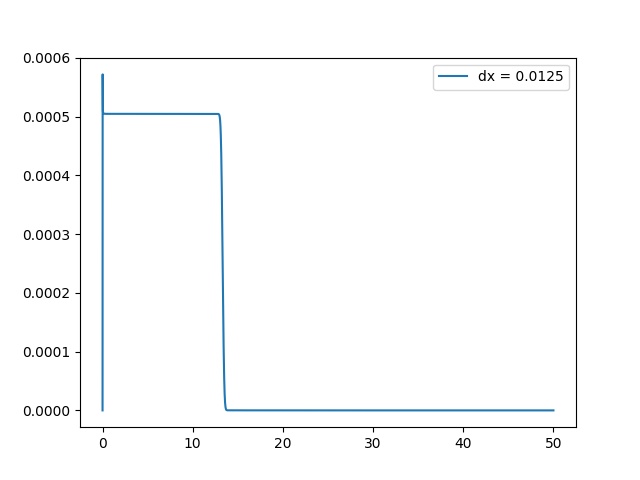

In [6]:
fig = plt.figure()
# plt.plot(X, Rho1, label = f"dx = {saved[k]['dx']}")
for k in range(len(dxs)):
    plt.plot(saved[k]['x'], saved[k]['rho'], label = f"dx = {saved[k]['dx']}")

# plt.plot(saved[3]['x'], saved[3]['rho'], label = f"new")
# plt.plot(saved_old[3]['x'], saved_old[3]['rho'], '--', label = f"old")


plt.legend()
# plt.xlim(0.9*X[np.argmax(Rho1)], 1.1*X[np.argmax(Rho1)])

In [11]:
Is = {}

for k in range(n_div-2):
    Is[k] = {}
    Is[k]['h']  = saved[k]['B'][:-1]
    Is[k]['h/2'] = np.array([0.5*(saved[k+1]['B'][i]+saved[k+1]['B'][i+1]) for i in range(0, len(saved[k+1]['B'])-1, 2)])
    Is[k]['h/4'] = np.array([0.25*(saved[k+2]['B'][i]+saved[k+2]['B'][i+1]+saved[k+2]['B'][i+2]+saved[k+2]['B'][i+3]) for i in range(0, len(saved[k+2]['B'])-3, 4)])

p = {}
for k in range(n_div-2):
    p[k] = np.log2( (Is[k]['h'] - Is[k]['h/2']) / (Is[k]['h/2'] - Is[k]['h/4']) )

p_L1 = np.zeros(n_div-2)
for k in range(n_div-2):
    p_L1[k] = np.log2( np.sum(np.abs((Is[k]['h'] - Is[k]['h/2']))) / np.sum(np.abs((Is[k]['h/2'] - Is[k]['h/4']))) )

/tmp/ipykernel_404/698818452.py:11: RuntimeWarning: invalid value encountered in log2
  p[k] = np.log2( (Is[k]['h'] - Is[k]['h/2']) / (Is[k]['h/2'] - Is[k]['h/4']) )


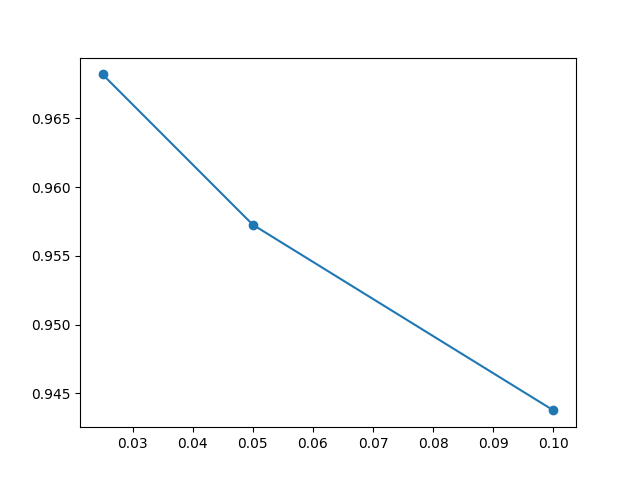

In [12]:
fig = plt.figure()
plt.plot(dxs[:n_div-2], p_L1, 'o-')